In [1]:
!pip install opencv-python torchsummary scikit-learn

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch.cuda.get_arch_list(), device)

['sm_37', 'sm_50', 'sm_60', 'sm_61', 'sm_70', 'sm_75', 'sm_80', 'sm_86', 'compute_37'] cuda


In [4]:
import os
from tqdm import notebook
from sklearn.metrics import classification_report, confusion_matrix
import gc
import matplotlib.pyplot as plt
import matplotlib.colors as mat_color
import numpy as np
from PIL import Image
import random
import cv2
from torchvision.datasets import ImageNet, ImageFolder
from torch.utils.data import DataLoader

In [5]:
train_path = './data/Covid-19 Image Dataset/train'
test_path = './data/Covid-19 Image Dataset/test'
base_path = './data'
base_folder = "Covid-19 Image Dataset"
classic_folder = 'Coivd-19_Classic'
synthetic_folder = 'Coivd-19_Synthetic'

In [6]:
labels = os.listdir(train_path)
print(labels)
no_norm = mat_color.Normalize(vmin=0, vmax=255, clip=False)

['Covid', 'Normal', 'Viral Pneumonia']


In [7]:
def load_random_imgs_from_folder(folder, label):
    plt.figure(figsize=(15, 15))
    for i in range(3):
        file = random.choice(os.listdir(folder))
        image_path = os.path.join(folder, file)
        img_bgr = cv2.imread(image_path)
        img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        ax = plt.subplot(1, 3, i+1)
        ax.title.set_text(label)
        plt.xlabel(f'Name: {file} , "Size: {img.shape}"')
        plt.imshow(img, norm=no_norm)

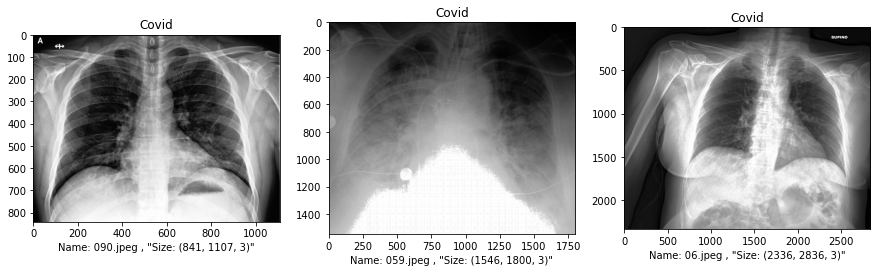

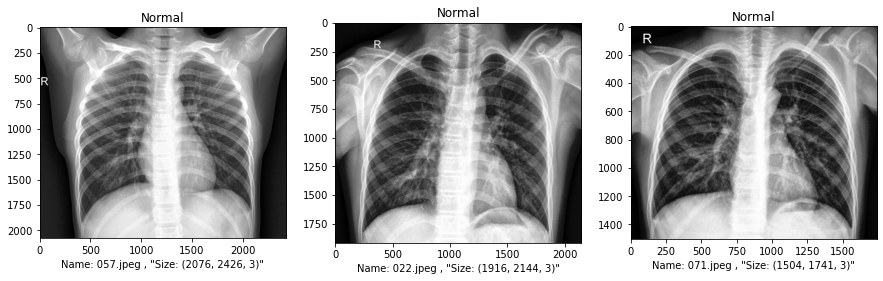

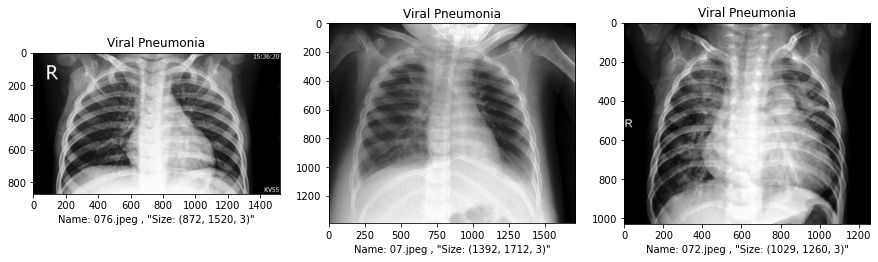

In [8]:
for label in labels:
    load_random_imgs_from_folder(f"{train_path}/{label}",label)

In [9]:
for func in [lambda: os.mkdir(os.path.join(base_path, classic_folder)),
             lambda: os.mkdir(os.path.join(base_path, synthetic_folder)),
             lambda: os.mkdir(os.path.join(os.path.join(base_path, classic_folder), 'train')),
             lambda: os.mkdir(os.path.join(os.path.join(base_path, classic_folder), 'test')),
             lambda: os.mkdir(os.path.join(os.path.join(base_path, synthetic_folder), 'train')),
             lambda: os.mkdir(os.path.join(os.path.join(base_path, synthetic_folder), 'test'))
            ]:
    try:
        func()
    except Exception as error:
        print(error)
        continue

In [10]:
def func_2():
    for label in labels:
        os.mkdir(os.path.join(os.path.join(os.path.join(base_path, synthetic_folder), 'test'), label))
        os.mkdir(os.path.join(os.path.join(os.path.join(base_path, synthetic_folder), 'train'), label))
        os.mkdir(os.path.join(os.path.join(os.path.join(base_path, classic_folder), 'test'), label))
        os.mkdir(os.path.join(os.path.join(os.path.join(base_path, classic_folder), 'train'), label))
try:
    func_2()
except Exception as error:
    print(error)

In [11]:
Config = {
    "ORI": 2,
    "ROT": 2,
    "H_FL": 2,
    "PER": 1,
    "AFF_S": 2,
    "AFF_T": 2,
    "COL": 2,
    "PAD": 1
}
for item in Config:
    Config[item] = round(Config[item]/1)
print(Config)

{'ORI': 1, 'ROT': 1, 'H_FL': 1, 'PER': 0, 'AFF_S': 1, 'AFF_T': 1, 'COL': 2, 'PAD': 0}


In [12]:
img_size = 128
a_degrees = 12
a_distortion_scale = 0.2
a_scale = (0.8, 1.2)
a_translate = (0.133, 0.133)
a_jitter = [0.3, 0.3, 0.3, 0.3]
a_padding_ratio = 0.067

In [13]:
def show_classic_aug(image_path):
    print("image_path ->", image_path)
    image = Image.open(image_path)
#     image = transforms.Resize((img_size, img_size), interpolation=2)(image)
#     image = transforms.ToTensor()(image)
    img_aug, names = [], []
    img_aug.append(image)
    names.append("Original-Image")
    img_aug.append(transforms.RandomRotation(degrees=(-a_degrees, a_degrees))(image))
    names.append("RandomRotation")
    img_aug.append(transforms.RandomHorizontalFlip(p=1)(image))
    names.append("RandomHorizontalFlip")
    img_aug.append(transforms.RandomPerspective(distortion_scale=a_distortion_scale, p=0.5)(image))
    names.append("RandomPerspective")
    img_aug.append(transforms.RandomAffine(degrees=0, scale=a_scale)(image))
    names.append("RandomAffine-Scale")
    img_aug.append(transforms.RandomAffine(degrees=0, translate=a_translate)(image))
    names.append("RandomAffine-Translate")
    img_aug.append(transforms.ColorJitter(brightness=a_jitter[0], 
                                          contrast=a_jitter[1], 
                                          saturation=a_jitter[2], 
                                          hue=a_jitter[3])(image))
    names.append("ColorJitter")
    img_aug.append(transforms.Pad(padding=round(a_padding_ratio * img_size),
                                  fill=0,
                                  padding_mode='symmetric')(image))
    names.append("Pad")
    plt.figure(figsize=(20, 10))
    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.imshow(img_aug[i], norm=no_norm)
        plt.title(names[i])
    plt.show()

image_path -> ./data/Covid-19 Image Dataset/train/Viral Pneumonia/023.jpeg


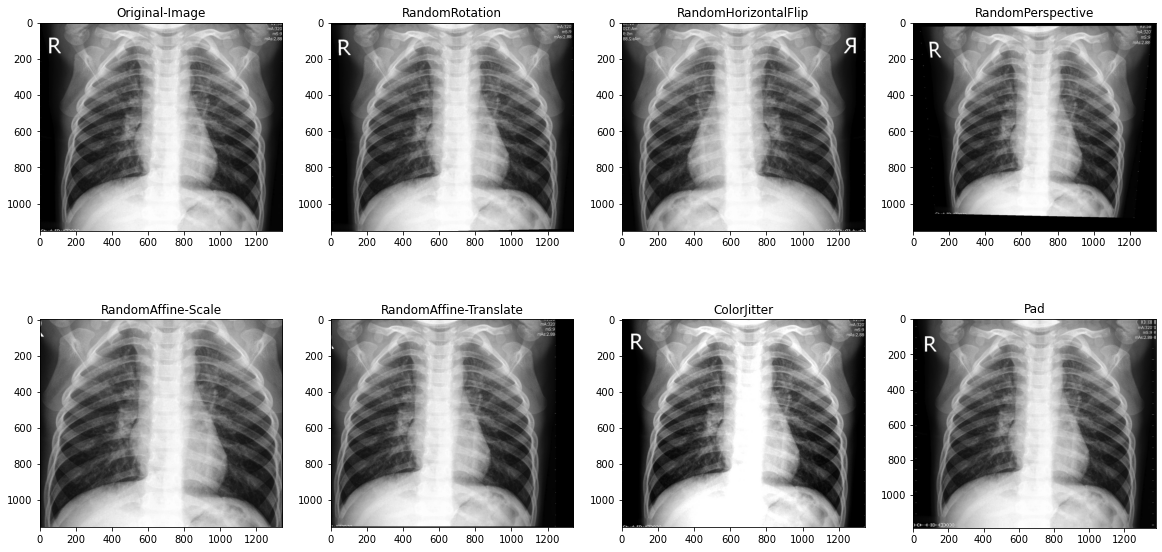

In [14]:
random_label = random.choice(os.listdir(train_path))
show_classic_aug(train_path + "/" + random_label + "/" + random.choice(os.listdir(train_path + "/" + random_label)))

In [15]:
def build_transforms():
    transform_list = []
    for i in range(Config["ROT"]):
        transform_list.append(transforms.RandomApply([transforms.RandomRotation(degrees=(-a_degrees, a_degrees))], p=0.5))
    for i in range(Config["H_FL"]):
        transform_list.append(transforms.RandomHorizontalFlip(p=0.5))
    for i in range(Config["PER"]):
        transform_list.append(transforms.RandomPerspective(distortion_scale=a_distortion_scale, p=0.5))
    for i in range(Config["AFF_S"]):
        transform_list.append(transforms.RandomApply([transforms.RandomAffine(degrees=0,
                                                                              scale=a_scale)], p=0.5))
    for i in range(Config["AFF_T"]):
        transform_list.append(transforms.RandomApply([transforms.RandomAffine(degrees=0,
                                                                              translate=a_translate)], p=0.5))
    for i in range(Config["COL"]):
        transform_list.append(transforms.RandomApply([transforms.ColorJitter(brightness=a_jitter[0], 
                                                                             contrast=a_jitter[1], 
                                                                             saturation=a_jitter[2], 
                                                                             hue=a_jitter[3])], p=0.5))
    for i in range(Config["PAD"]):
        transform_list.append(transforms.RandomApply([transforms.Pad(padding=round(a_padding_ratio * img_size),
                                                                     fill=0,
                                                                     padding_mode='symmetric')], p=0.5))
    transform_list.append(transforms.Resize((img_size, img_size),interpolation=2))
    transform_list.append(transforms.ToTensor())
    transform = transforms.Compose(transform_list)
    test_transform = transforms.Compose([transforms.Resize((img_size, img_size), interpolation=2),
                                         transforms.ToTensor(),
                                        ])
    return transform, test_transform

In [16]:
def generator_data(transform, test_transform):
    train_dataset = ImageFolder(root=train_path, transform=transform)
    train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    test_dataset = ImageFolder(root=test_path, transform=test_transform)
    test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)
    dataset_list = [train_dataset, test_dataset]
    dataloader_list = [train_dataloader, test_dataloader]
    return dataset_list, dataloader_list

In [17]:
transform, test_transform = build_transforms()
dataset_list, dataloader_list = generator_data(transform, test_transform)

D:\Miniconda3\envs\torch_1-11\lib\site-packages\torchvision\transforms\transforms.py:332: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [18]:
def generate_classic_aug_unit(image_path, image_name):
    """
    the path needs to be specific to each .jpg file
    """
    print("image_path ->", image_path)
    image = Image.open(image_path)
#     image = transforms.Resize((img_size, img_size), interpolation=2)(image)
#     image = transforms.ToTensor()(image)
    img_aug, names = [], []
    for i in range(Config["ORI"]):
        img_aug.append(image)
        names.append(image_name + "Original-Image" + "_" + str(i + 1) + ".jpg")
    for i in range(Config["ROT"]):
        img_aug.append(transforms.RandomRotation(degrees=(-a_degrees, a_degrees))(image))
        names.append(image_name + "RandomRotation" + "_" + str(i + 1) + ".jpg")
    for i in range(Config["H_FL"]):
        img_aug.append(transforms.RandomHorizontalFlip(p=1)(image))
        names.append(image_name + "RandomHorizontalFlip" + "_" + str(i + 1) + ".jpg")
    for i in range(Config["PER"]):
        img_aug.append(transforms.RandomPerspective(distortion_scale=a_distortion_scale, p=0.5)(image))
        names.append(image_name + "RandomPerspective" + "_" + str(i + 1) + ".jpg")
    for i in range(Config["AFF_S"]):
        img_aug.append(transforms.RandomAffine(degrees=0, scale=a_scale)(image))
        names.append(image_name + "RandomAffine-Scale" + "_" + str(i + 1) + ".jpg")
    for i in range(Config["AFF_T"]):
        img_aug.append(transforms.RandomAffine(degrees=0, translate=a_translate)(image))
        names.append(image_name + "RandomAffine-Translate" + "_" + str(i + 1) + ".jpg")
    for i in range(Config["COL"]):
        img_aug.append(transforms.ColorJitter(brightness=a_jitter[0], 
                                              contrast=a_jitter[1], 
                                              saturation=a_jitter[2], 
                                              hue=a_jitter[3])(image))
        names.append(image_name + "ColorJitter" + "_" + str(i + 1) + ".jpg")
    for i in range(Config["PAD"]):
        img_aug.append(transforms.Pad(padding=round(a_padding_ratio * img_size),
                                      fill=0,
                                      padding_mode='symmetric')(image))
        names.append(image_name + "Pad" + "_" + str(i + 1) + ".jpg")
    return img_aug, names

In [19]:
def save_classic_aug(image, path):
    try:
        image = image.convert('RGB')
        image.save(path)
    except (ValueError, KeyError, OSError) as err:
        print(err)
        return None

In [20]:
def generate_classic_aug_all(train_path, test_path):
    count = 0
    for path in [train_path, test_path]:
        for label in labels:
            label_path = os.path.join(path, label)
            image_name_list = os.listdir(label_path)
            for image_name in image_name_list:
                image_path = os.path.join(label_path, image_name)
                if image_path[-2] == 'e':# 
                    image_name=image_path.replace(base_folder, classic_folder)[:-5]
                elif  image_path[-2] == 'n' or image_path[-2] == 'p':
                    image_name=image_path.replace(base_folder, classic_folder)[:-4]
                else:
                    print("!!!", image_path)
                    return None
                cur_image_aug_list, cur_image_name_list = generate_classic_aug_unit(image_path=image_path, 
                                                                                    image_name=image_name)
                size = len(cur_image_aug_list)
                count += size
                print(cur_image_name_list[0])
                for i in range(size):
                    save_classic_aug(cur_image_aug_list[i], cur_image_name_list[i])
    print("classic augmentation process done! total count ->", count)

In [21]:
generate_classic_aug_all(train_path, test_path)

image_path -> ./data/Covid-19 Image Dataset/train\Covid\01.jpeg
./data/Coivd-19_Classic/train\Covid\01Original-Image_1.jpg
image_path -> ./data/Covid-19 Image Dataset/train\Covid\010.png
./data/Coivd-19_Classic/train\Covid\010Original-Image_1.jpg
image_path -> ./data/Covid-19 Image Dataset/train\Covid\012.jpeg
./data/Coivd-19_Classic/train\Covid\012Original-Image_1.jpg
image_path -> ./data/Covid-19 Image Dataset/train\Covid\015.jpg
./data/Coivd-19_Classic/train\Covid\015Original-Image_1.jpg
image_path -> ./data/Covid-19 Image Dataset/train\Covid\019.png
./data/Coivd-19_Classic/train\Covid\019Original-Image_1.jpg
image_path -> ./data/Covid-19 Image Dataset/train\Covid\02.jpeg
./data/Coivd-19_Classic/train\Covid\02Original-Image_1.jpg
image_path -> ./data/Covid-19 Image Dataset/train\Covid\020.jpg
./data/Coivd-19_Classic/train\Covid\020Original-Image_1.jpg
image_path -> ./data/Covid-19 Image Dataset/train\Covid\021.jpeg
./data/Coivd-19_Classic/train\Covid\021Original-Image_1.jpg
image_pa

image_path -> ./data/Covid-19 Image Dataset/train\Covid\09.png
./data/Coivd-19_Classic/train\Covid\09Original-Image_1.jpg
image_path -> ./data/Covid-19 Image Dataset/train\Covid\090.jpeg
./data/Coivd-19_Classic/train\Covid\090Original-Image_1.jpg
image_path -> ./data/Covid-19 Image Dataset/train\Covid\091.jpg
./data/Coivd-19_Classic/train\Covid\091Original-Image_1.jpg
image_path -> ./data/Covid-19 Image Dataset/train\Covid\092.png
./data/Coivd-19_Classic/train\Covid\092Original-Image_1.jpg
image_path -> ./data/Covid-19 Image Dataset/train\Covid\COVID-00001.jpg
./data/Coivd-19_Classic/train\Covid\COVID-00001Original-Image_1.jpg
image_path -> ./data/Covid-19 Image Dataset/train\Covid\COVID-00002.jpg
./data/Coivd-19_Classic/train\Covid\COVID-00002Original-Image_1.jpg
image_path -> ./data/Covid-19 Image Dataset/train\Covid\COVID-00003a.jpg
./data/Coivd-19_Classic/train\Covid\COVID-00003aOriginal-Image_1.jpg
image_path -> ./data/Covid-19 Image Dataset/train\Covid\COVID-00003b.jpg
./data/Coi

./data/Coivd-19_Classic/train\Normal\023Original-Image_1.jpg
image_path -> ./data/Covid-19 Image Dataset/train\Normal\024.jpeg
./data/Coivd-19_Classic/train\Normal\024Original-Image_1.jpg
image_path -> ./data/Covid-19 Image Dataset/train\Normal\025.jpeg
./data/Coivd-19_Classic/train\Normal\025Original-Image_1.jpg
image_path -> ./data/Covid-19 Image Dataset/train\Normal\03.jpeg
./data/Coivd-19_Classic/train\Normal\03Original-Image_1.jpg
image_path -> ./data/Covid-19 Image Dataset/train\Normal\04.jpeg
./data/Coivd-19_Classic/train\Normal\04Original-Image_1.jpg
image_path -> ./data/Covid-19 Image Dataset/train\Normal\05.jpeg
./data/Coivd-19_Classic/train\Normal\05Original-Image_1.jpg
image_path -> ./data/Covid-19 Image Dataset/train\Normal\050.jpeg
./data/Coivd-19_Classic/train\Normal\050Original-Image_1.jpg
image_path -> ./data/Covid-19 Image Dataset/train\Normal\051.jpeg
./data/Coivd-19_Classic/train\Normal\051Original-Image_1.jpg
image_path -> ./data/Covid-19 Image Dataset/train\Normal

image_path -> ./data/Covid-19 Image Dataset/train\Viral Pneumonia\020.jpeg
./data/Coivd-19_Classic/train\Viral Pneumonia\020Original-Image_1.jpg
image_path -> ./data/Covid-19 Image Dataset/train\Viral Pneumonia\021.jpeg
./data/Coivd-19_Classic/train\Viral Pneumonia\021Original-Image_1.jpg
image_path -> ./data/Covid-19 Image Dataset/train\Viral Pneumonia\022.jpeg
./data/Coivd-19_Classic/train\Viral Pneumonia\022Original-Image_1.jpg
image_path -> ./data/Covid-19 Image Dataset/train\Viral Pneumonia\023.jpeg
./data/Coivd-19_Classic/train\Viral Pneumonia\023Original-Image_1.jpg
image_path -> ./data/Covid-19 Image Dataset/train\Viral Pneumonia\024.jpeg
./data/Coivd-19_Classic/train\Viral Pneumonia\024Original-Image_1.jpg
image_path -> ./data/Covid-19 Image Dataset/train\Viral Pneumonia\025.jpeg
./data/Coivd-19_Classic/train\Viral Pneumonia\025Original-Image_1.jpg
image_path -> ./data/Covid-19 Image Dataset/train\Viral Pneumonia\027.jpeg
./data/Coivd-19_Classic/train\Viral Pneumonia\027Origin

image_path -> ./data/Covid-19 Image Dataset/train\Viral Pneumonia\09.jpeg
./data/Coivd-19_Classic/train\Viral Pneumonia\09Original-Image_1.jpg
image_path -> ./data/Covid-19 Image Dataset/train\Viral Pneumonia\094.jpeg
./data/Coivd-19_Classic/train\Viral Pneumonia\094Original-Image_1.jpg
image_path -> ./data/Covid-19 Image Dataset/train\Viral Pneumonia\095.jpeg
./data/Coivd-19_Classic/train\Viral Pneumonia\095Original-Image_1.jpg
image_path -> ./data/Covid-19 Image Dataset/train\Viral Pneumonia\096.jpeg
./data/Coivd-19_Classic/train\Viral Pneumonia\096Original-Image_1.jpg
image_path -> ./data/Covid-19 Image Dataset/test\Covid\0100.jpeg
./data/Coivd-19_Classic/test\Covid\0100Original-Image_1.jpg
image_path -> ./data/Covid-19 Image Dataset/test\Covid\0102.jpeg
./data/Coivd-19_Classic/test\Covid\0102Original-Image_1.jpg
image_path -> ./data/Covid-19 Image Dataset/test\Covid\0105.png
./data/Coivd-19_Classic/test\Covid\0105Original-Image_1.jpg
image_path -> ./data/Covid-19 Image Dataset/test

./data/Coivd-19_Classic/test\Viral Pneumonia\0108Original-Image_1.jpg
image_path -> ./data/Covid-19 Image Dataset/test\Viral Pneumonia\0109.jpeg
./data/Coivd-19_Classic/test\Viral Pneumonia\0109Original-Image_1.jpg
image_path -> ./data/Covid-19 Image Dataset/test\Viral Pneumonia\0110.jpeg
./data/Coivd-19_Classic/test\Viral Pneumonia\0110Original-Image_1.jpg
image_path -> ./data/Covid-19 Image Dataset/test\Viral Pneumonia\0111.jpeg
./data/Coivd-19_Classic/test\Viral Pneumonia\0111Original-Image_1.jpg
image_path -> ./data/Covid-19 Image Dataset/test\Viral Pneumonia\0112.jpeg
./data/Coivd-19_Classic/test\Viral Pneumonia\0112Original-Image_1.jpg
image_path -> ./data/Covid-19 Image Dataset/test\Viral Pneumonia\0113.jpeg
./data/Coivd-19_Classic/test\Viral Pneumonia\0113Original-Image_1.jpg
image_path -> ./data/Covid-19 Image Dataset/test\Viral Pneumonia\0114.jpeg
./data/Coivd-19_Classic/test\Viral Pneumonia\0114Original-Image_1.jpg
image_path -> ./data/Covid-19 Image Dataset/test\Viral Pneum